In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [100]:
df = pd.read_csv('BTC-USD.csv', parse_dates=[0])
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2819,2022-06-06,29910.283203,31693.291016,29894.187500,31370.671875,31370.671875,31947336829
2820,2022-06-07,31371.742188,31489.683594,29311.683594,31155.478516,31155.478516,40770974039
2821,2022-06-08,31151.480469,31253.691406,29944.404297,30214.355469,30214.355469,30242059107
2822,2022-06-09,30215.279297,30609.310547,30020.265625,30111.998047,30111.998047,21692004719


In [101]:
from thinkdsp import Wave
ys = df['Close']
ts = df.index
wave = Wave(ys, ts, framerate=1)

In [102]:
def serial_corr(wave, lag=1):
    n = len(wave)
    y1 = wave.ys[lag:]
    y2 = wave.ys[:n-lag]
    corr = np.corrcoef(y1, y2, ddof=0)[0, 1]
    return corr
    
def autocorr(wave):
    lags = range(len(wave.ys)//2)
    corrs = [serial_corr(wave, lag) for lag in lags]
    return lags, corrs

C:\Users\a9876\AppData\Local\Temp/ipykernel_226668/605067872.py:5: DeprecationWarning: bias and ddof have no effect and are deprecated
  corr = np.corrcoef(y1, y2, ddof=0)[0, 1]


max correlation lag: 1199  max corr: 0.8899863732963679


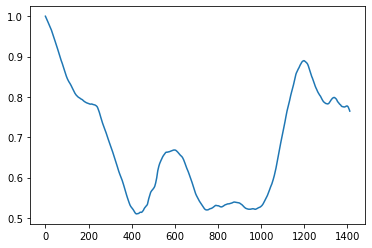

In [103]:
# example of finding the autocorrelation of a wave
lags, corrs = autocorr(wave)
max_corr = max(corrs[100:])   # lag->0, corr always->1, so remove it
max_corr_index = corrs.index(max_corr)
print('max correlation lag:', max_corr_index,' max corr:', max_corr)
plt.plot(lags, corrs)

In [104]:
def predict_trend(wave, current_time, window_size):
    new_wave = wave.copy()
    new_wave.ys = new_wave.ys[:current_time]
    lags, corrs = autocorr(new_wave)
    max_corr = max(corrs[100:])   # lag->0, corr always->1, so remove it
    max_corr_index = corrs.index(max_corr)
    # print('max_corr_index',max_corr_index,'; max_corr',max_corr)

    next_average = np.mean(np.array(wave.ys[max_corr_index+1:max_corr_index+1+window_size]))
    return (max_corr,next_average-wave.ys[max_corr_index])

In [105]:
# test the function
print(predict_trend(wave,len(wave),7))

(0.8899863732963679, 197.74274571428577)


C:\Users\a9876\AppData\Local\Temp/ipykernel_226668/605067872.py:5: DeprecationWarning: bias and ddof have no effect and are deprecated
  corr = np.corrcoef(y1, y2, ddof=0)[0, 1]


In [106]:
def cal_profit(wave, start, end, amount, window_size, trend_threshold, corr_threshold):
    profit = []
    for day in range(start,end):
        (corr,trend) = predict_trend(wave, day, window_size)
        if trend>trend_threshold and corr>corr_threshold:
            profit.append((wave.ys[day+window_size] - wave.ys[day]) * amount) 
    return profit

C:\Users\a9876\AppData\Local\Temp/ipykernel_226668/605067872.py:5: DeprecationWarning: bias and ddof have no effect and are deprecated
  corr = np.corrcoef(y1, y2, ddof=0)[0, 1]


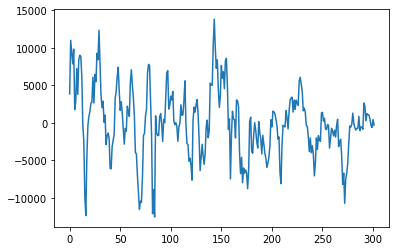

In [119]:
window_size = 7
trend_threshold = 20
corr_threshold = 0.85
profit = cal_profit(wave, 1000, len(wave)-1-window_size, 1, window_size, trend_threshold, corr_threshold)
plt.plot(profit)

In [120]:
np.sum(profit)

-11126.736326999991